Notebook for walking through example 1 in concept chapter of thesis.

Simulates the movement of 3 individuals over 5 timesteps, makes detections using a camera moving across the survey area in one axis

**Setup starting Positions**

Sim variables:

1. survey area
2. Number of individuals

In [1]:

survey_x = 5
survey_y = 1

n_inds = 3

Randomise starting points of the individuals

In [2]:
import numpy as np
from src.simulate import initial_positions

In [3]:
area = [0, survey_x, 0, survey_y]

starting_x, starting_y = initial_positions(n_inds, area)
starting_x = [.8, 2., 4.] 

Plot starting scenario

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

%matplotlib notebook


<IPython.core.display.Javascript object>


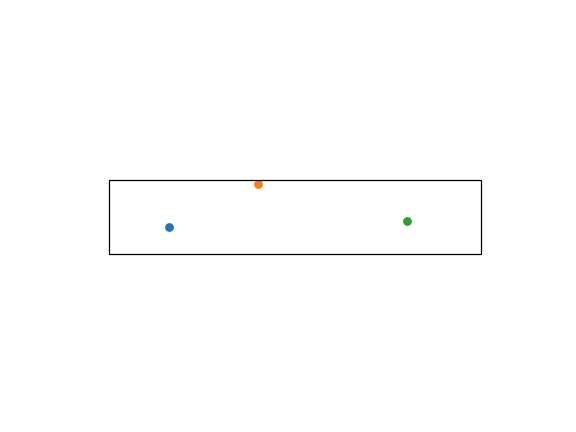

In [5]:
fig, ax = plt.subplots()

for x,y in zip(starting_x, starting_y):
    ax.scatter(x, y)

ax.axis('equal')
ax.set_xlim(0-.5, survey_x + .5)
ax.set_ylim(0-.5, survey_y + .5)

ax.axis('off')

ax.add_patch(Rectangle((0,0), survey_x, survey_y, fill=False))

plt.show()


**Simulate vehicle track**

Vehicle parameters:
1. camera area
2. vehicle step size

Animal parameter:
1. Variance

In [6]:
cam_area = [1, 1]
c_step = 0.6

var = 0.1

Camera moves along X axis by c_step every timestep

In [7]:
cam_starting_x = 0

c_x = 0

cam_x = [c_x]
while c_x+cam_area[0] < survey_x:
    c_x += c_step
    cam_x.append(c_x)

cam_y = [0]*len(cam_x)

<IPython.core.display.Javascript object>


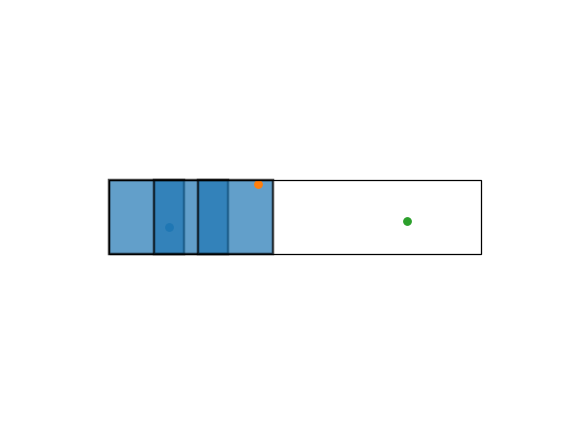

In [48]:
fig, ax = plt.subplots()


for x, y in zip(cam_x[:3], cam_y[:3]):
    ax.add_patch(Rectangle((x,y), cam_area[0], cam_area[1], edgecolor='black', linewidth=2, alpha=0.7, zorder=0))
    
for x,y in zip(starting_x, starting_y):
    ax.scatter(x, y)
    
ax.axis('square')
ax.set_xlim(0-.5, survey_x + .5)
ax.set_ylim(0-.5, survey_y + .5)


ax.axis('off')

ax.add_patch(Rectangle((0,0), survey_x, survey_y, fill=False))


plt.show()


**Simulate animal movement and detections**

In [9]:
n_steps = len(cam_x)

In [26]:
def simulate2(starting, norm):
    return [s + np.random.normal(0, norm, 2) for s in starting]

def simulate1(starting, norm):
    return [s + np.random.normal(0, norm) for s in starting]

def simulate(starting, norm, n_steps, d2=False):
    s = [starting]
    for i in range(n_steps):
        if d2:
            s.append(simulate2(s[i], norm))
        else:
            s.append(simulate1(s[i], norm))
    
    return np.array(s)

In [27]:
starting = np.array([[x,y] for x,y in zip(starting_x, starting_y)])

positions = simulate(starting, var, n_steps, d2=True)
    

<IPython.core.display.Javascript object>


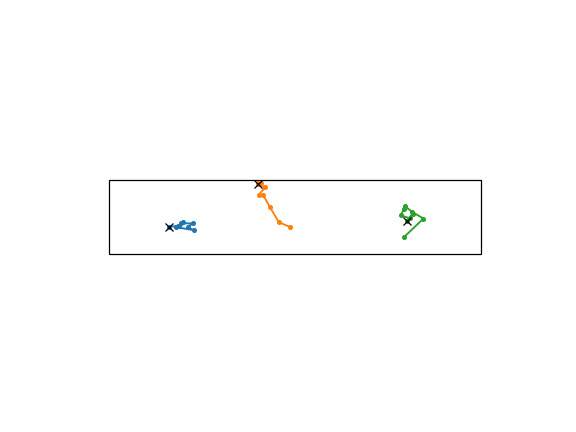

In [28]:
fig, ax = plt.subplots()

for i in range(n_inds):
    ax.plot(positions[:, i, 0], positions[:, i, 1], '-o', markersize=3)

ax.plot(starting_x, starting_y, 'kx')
ax.axis('square')
ax.set_xlim(0-.5, survey_x + .5)
ax.set_ylim(0-.5, survey_y + .5)


ax.axis('off')

ax.add_patch(Rectangle((0,0), survey_x, survey_y, fill=False))

fig.show()

Now that we have the animal tracks and camera path, go through step by step to get the detections (i.e. when an animal is in frame of the camera)

In [29]:
def in_cam(cam_x, cam_y, t, footprint, positions):
    cx = cam_x[t]
    cy = cam_y[t]
 
    pos = positions[t]

    dets = []

    for p in pos:

        inx = np.logical_and(cx  <= p[0], p[0] <= cx + cam_area[0])
        iny = np.logical_and(cy  <= p[1], p[1] <= cy + cam_area[1])
        dets.append([np.logical_and(inx, iny)])
    return dets
    
    

In [30]:
detections = []

for t in range(n_steps):
    d = in_cam(cam_x, cam_y, t, cam_area, positions)
    # each detection is [timestep, individual]
    npw = np.where(d)
    if len(npw[0]) >0:
        for ind in npw[0]:
            detections.append([t, ind])
    

In [31]:
clrs = plt.rcParams['axes.prop_cycle'].by_key()['color'][:3]

<IPython.core.display.Javascript object>


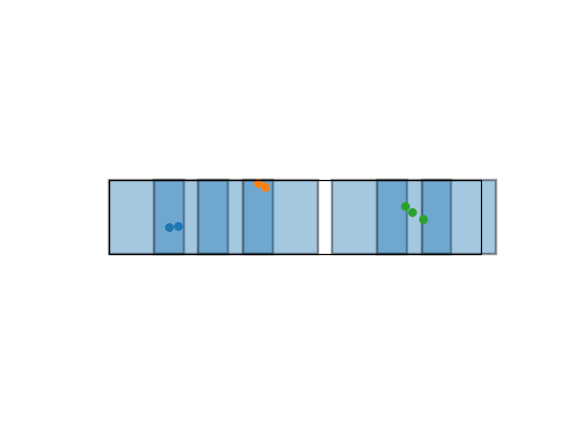

In [46]:
fig, ax = plt.subplots()

for d in detections:
    t = d[0]
    ind = d[1]
    
    pos = positions[t][ind]
    ax.scatter(pos[0], pos[1], color=clrs[ind])
    ax.add_patch(Rectangle((cam_x[t], cam_y[t]), cam_area[0], cam_area[1], edgecolor='black', linewidth=2, alpha=0.4, zorder=0))
    
ax.axis('square')
ax.set_xlim(0-.5, survey_x + .5)
ax.set_ylim(0-.5, survey_y + .5)


ax.axis('off')

ax.add_patch(Rectangle((0,0), survey_x, survey_y, fill=False))

plt.show()
    

**Build and score hypotheses**

In [33]:
det_arr = np.array(detections)
det_arr

array([[0, 0],
       [1, 0],
       [2, 1],
       [3, 1],
       [5, 2],
       [6, 2],
       [7, 2]], dtype=int64)

get detection info together iin a dataframe

In [34]:
import pandas as pd

In [35]:
df = pd.DataFrame(columns=['time', 'individual', 'x', 'y'])
df["time"] = det_arr[:, 0]
df["individual"] = det_arr[:, 1]

In [36]:
df["x"] = df.apply(lambda row: positions[row["time"], row["individual"], 0], axis=1)
df["y"] = df.apply(lambda row: positions[row["time"], row["individual"], 1], axis=1)

In [37]:
df

,time,individual,x,y
0,0,0,0.800000,0.369555
1,1,0,0.918349,0.381728
2,2,1,1.994714,0.955228
3,3,1,2.096249,0.899688
4,5,2,3.974920,0.651360
5,6,2,4.067293,0.573218
6,7,2,4.224042,0.481417


In [38]:
def update_tracks(det, hyps):
    new_hyps=[]
    for i, hyp in enumerate(hyps):
        missed_scen = hyp + [np.nan]
        new_hyps.append( missed_scen )
        
        for detection_id in det.index:
            repeat_scen = hyp + [detection_id]
            new_hyps.append(repeat_scen)
    return new_hyps

In [53]:
t = 0
det = df[df.time == t]

tracks = [[i] for i,row in det.iterrows()]
tracks.append([np.nan])

In [54]:
tracks

[[0], [nan]]

In [55]:
t = 1
det = df[df.time == t]
tracks = update_tracks(det, tracks)
tracks

[[0, nan], [0, 1], [nan, nan], [nan, 1]]

In [41]:
for t in df.time.unique()[1:]:
    det = df[df.time == t]
    
    tracks = update_tracks(det, tracks)

In [44]:
df

,time,individual,x,y
0,0,0,0.800000,0.369555
1,1,0,0.918349,0.381728
2,2,1,1.994714,0.955228
3,3,1,2.096249,0.899688
4,5,2,3.974920,0.651360
5,6,2,4.067293,0.573218
6,7,2,4.224042,0.481417


In [50]:
tr = np.array(tracks)

In [52]:
tr[:, :3]

array([[ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0.,  1., nan],
       [ 0.,  1., nan],
       [ 0.,  1., nan],
       [ 0.,  1., nan],
       [ 0.,  1., nan],
       [ 0.,  1., nan],
       [ 0.,  1., nan],
       [ 0.,  1., nan],
       [ 0.,  1., nan],
       [ 0.,  1.

**Analyse predicted distributions**